In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime as dt
import numpy as np
from scipy.stats.stats import pearsonr  
from sklearn.preprocessing import normalize

plt.style.use('ggplot')
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("data/churn_dataset.csv")
df_cluster = pd.read_csv('data/clustered_customers.csv')[['customer_db_id', 'cluster']]
df = df.merge(df_cluster, on='customer_db_id', how='left')

In [4]:
df.shape

(193932, 87)

In [5]:
df.head().T

,0,1,2,3,4
customer_db_id,54478736d4cde82247f1345f,54478fa4d3cde8d17ca5e4db,5447eefcd3cde8cf7ca5e4eb,5447f1a2d4cde82147f1347d,544976fad4cde8f3415bedb0
customer_id,GB-CUS-Y8922200,GB-CUS-K3854440,GB-CUS-L2277081,GB-CUS-C3589820,GB-CUS-P7798401
gender,male,female,male,male,male
segment,NaN,RED,NaN,NaN,NaN
aov,NaN,10.1501,NaN,NaN,NaN
recency,1385,1226,1385,1385,1205
frequency,0,0,0,0,0
churn_factor,1,1,1,1,1
referred,False,False,False,False,False
newsletter_optin,False,False,False,False,False


# Preprocessing

In [6]:
df['churned'] = [True if x > 1 else False for x in df.churn_factor]
df['first_order_voucher_revenue_ratio'] = df.first_order_voucher_value / (df.first_order_voucher_value + df.first_order_revenue)

## Fill NAs

In [7]:
nans = df.isnull().sum()
nans[nans > 0].sort_values(ascending = False)

refunds_unsuccess                    192786
refunds_success                      177426
last_order_rating                    169081
rating_diff                          169081
last_order_voucher_channel           154169
first_order_voucher_channel          128686
first_order_rating                   123548
first_order_fac_name                  77357
last_order_voucher_value              73474
early_orders                          70490
late_orders                           68594
avg_rating                            51158
unpunctual_ratio                      50331
unpunctual_orders                     50291
laundry_rating                        39114
punctual                              36453
punctual_mins_ratio_DO                35673
first_order_recency                   30664
second_order_date                     30664
last_order_hub_distance               28227
punctual_mins_ratio_PU                24321
last_order_fac_name                   24250
first_order_products            

In [8]:
df['first_order_products'] = df['first_order_products'].fillna("")

In [9]:
df[['refunds_unsuccess', 'refunds_success']] = df[['refunds_unsuccess', 'refunds_success']].fillna(0)

In [10]:
rating_cols = ['avg_rating', 'rating_diff', 'last_order_rating', 'rated_orders', 'first_order_rating']
df[rating_cols] = df[rating_cols].fillna(-999)
df.loc[df.rated_orders > 0, rating_cols].head()

,avg_rating,rating_diff,last_order_rating,rated_orders,first_order_rating
31,5.000000,-999.0,-999.0,1,-999.0
33,4.821429,-999.0,-999.0,28,-999.0
34,4.821429,-999.0,-999.0,28,-999.0
35,4.821429,-999.0,-999.0,28,-999.0
36,4.821429,-999.0,-999.0,28,-999.0


In [11]:
df.aov = df.aov.fillna(0)
df.segment = df.segment.fillna('None')
df.gender = df.gender.fillna('Unknown')

In [12]:
df.zip = df.zip.fillna('Unknown')
df.zip_area = df.zip_area.fillna('Unknown')

df.avg_hub_distance = df.avg_hub_distance.fillna(-999)
df.last_order_hub_distance = df.last_order_hub_distance.fillna(-999)
df.first_order_hub_distance = df.first_order_hub_distance.fillna(-999)
df.laundry_distance = df.laundry_distance.fillna(-999)
df.laundry_rating = df.laundry_rating.fillna(-999)
df.laundry_within_1km = df.laundry_within_1km.fillna(-999)

In [13]:
df.first_order_date = pd.to_datetime(df.first_order_date)
df['first_order_week'] = df['first_order_date'].dt.week
df['first_order_year'] = df['first_order_date'].dt.year
df['first_order_day'] = df['first_order_date'].dt.day
df['first_order_month'] = df['first_order_date'].dt.month

In [14]:
df.first_order_fac_name = df.first_order_fac_name.fillna('unknown')
df.first_order_voucher_channel = df.first_order_voucher_channel.fillna('unknown')
df.first_order_voucher_value = df.first_order_voucher_value.fillna(-999)
df.first_order_voucher_revenue_ratio = df.first_order_voucher_revenue_ratio.fillna(0)
df.last_order_fac_name = df.last_order_fac_name.fillna('unknown')
df.last_order_voucher_channel = df.last_order_voucher_channel.fillna('unknown')
df.last_order_voucher_value = df.last_order_voucher_value.fillna(-999)

In [15]:
nans = df.isnull().sum()
nans[nans > 0].sort_values(ascending = False)

early_orders              70490
late_orders               68594
unpunctual_ratio          50331
unpunctual_orders         50291
punctual                  36453
punctual_mins_ratio_DO    35673
first_order_recency       30664
second_order_date         30664
punctual_mins_ratio_PU    24321
cluster                   21150
dtype: int64

## Label Encoding

In [16]:
voucher_channel_le = LabelEncoder()
voucher_channel_le.fit(df.first_order_voucher_channel)
df['first_order_voucher_channel_enc'] = voucher_channel_le.transform(df.first_order_voucher_channel.tolist())

products_le = LabelEncoder()
products_le.fit(df.first_order_products)
df['first_order_products_enc'] = products_le.transform(df.first_order_products.tolist())

facility_le = LabelEncoder()
facility_le.fit(df.first_order_fac_name)
df['first_order_fac_name_enc'] = facility_le.transform(df.first_order_fac_name.tolist())

order_date_le = LabelEncoder()
order_date_le.fit(df.first_order_date.sort_values().dt.strftime('%Y-%m-%d'))
df['first_order_date_enc'] = order_date_le.transform(df.first_order_date.dt.strftime('%Y-%m-%d').tolist())

# Bad vs Good Voucher Customers
*Assumption: Bad customers are customers who had one completed order using a voucher, had a good customer experience and didn't place another order for more than a year. These customers should be excluded from churn analysis.*

We want to analyse, if there are any specific features, such as area, channels, products that identify bad customers. In order to analyse, we create a comparison 'Good Customers' group, which are customers, who have returned after their first order with vouchers within a year.

Bad Voucher customers: 
- First_Order_Voucher == TRUE
- Completed_Orders == 1
- Total_Orders == 1
- Last_Order > 365 days ago

Good Voucher customers:
- First_Order_Voucher == TRUE
- Completed_Orders > 1
- Second completed order within a year

In [22]:
df_vou = df.loc[df.first_order_voucher & df.completed_orders > 0]
df_vou_good = df_vou.loc[(df_vou.completed_orders > 1) & (df_vou.first_order_recency < 365)]
df_vou_bad = df_vou.loc[(df_vou.completed_orders == 1) & (df_vou.total_orders == 1) & (df_vou.recency > 365)]

df_vou_bad = df_vou_bad.loc[df_vou_bad.first_order_date < "2017-07-21"]
df_vou_good = df_vou_good.loc[df_vou_good.first_order_date < "2017-07-21"]

In [23]:
print('Number of Bad customers: ', df_vou_bad.shape[0])
print('Number of Good customers: ', df_vou_good.shape[0])

df_vou_bad['customer_type'] = 'bad'
df_vou_good['customer_type'] = 'good'

Number of Bad customers:  7856
Number of Good customers:  19180


# Bad customers with Bad experience
*Assumption: If a BAD customer churned because of bad experience, he should be included in the churn analysis*

Customers falling into the following groups should not be excluded from analysis:
* reclean_order
* order_rating < 4
* internal_reschedules > 1
* refund

In [24]:
def plot_bad_vs_good_by_column(column_name):
    df_bad = df_vou_bad.groupby(column_name)['customer_db_id'].nunique() / df_vou_bad.shape[0]
    df_good = df_vou_good.groupby(column_name)['customer_db_id'].nunique() / df_vou_good.shape[0]
    df_diff = df_good - df_bad
    df_diff_relative = df_diff / (df_bad + df_good)
    df = pd.concat([df_bad, df_good, df_diff, df_diff_relative], 
                  axis=1, keys=['bad', 'good', 'diff', 'diff_relative'], sort=True)
    
    df = df.sort_values('diff', ascending=False)
    df[['bad', 'good']].plot(kind='bar', title=column_name)
    df[['diff']].plot(kind='bar', title='diff (+ more good / - more bad)', color='orange')
#     df[['diff_relative']].sort_values('diff_relative', ascending=False).plot(kind='bar', title='diff relative (diff / all customers)', color='orange')

In [25]:
df_vou_bad.groupby(['reclean_orders'])['customer_db_id'].nunique()

reclean_orders
0    6853
1      12
Name: customer_db_id, dtype: int64

In [26]:
df_vou_bad.groupby(['last_order_rating'])['customer_db_id'].nunique()

last_order_rating
-999.0    5696
 1.0       101
 2.0        37
 3.0       106
 4.0       247
 5.0       678
Name: customer_db_id, dtype: int64

In [27]:
df_vou_bad.groupby(['internal_reschedules'])['customer_db_id'].nunique()

internal_reschedules
0    6538
1     249
2      56
3      18
4       3
5       1
Name: customer_db_id, dtype: int64

In [28]:
df_vou_bad.groupby(['refunds_success'])['customer_db_id'].nunique()

refunds_success
0.0    6857
1.0       8
Name: customer_db_id, dtype: int64

In [29]:
df_vou_bad_exp = df_vou_bad.loc[
    (df_vou_bad.reclean_orders == 1) |
    ((df_vou_bad.last_order_rating < 4) & (df_vou_bad.last_order_rating > 0)) |
    (df_vou_bad.refunds_success == 1) |
    (df_vou_bad.internal_reschedules > 1)
]

df_vou_bad = df_vou_bad.loc[~df_vou_bad.customer_db_id.isin(df_vou_bad_exp.customer_db_id)]
df_both = pd.concat([df_vou_bad, df_vou_good])
df_both['customer_type_enc'] = df_both['customer_type'].map({'bad': -1, 'good': 1})

print('Bad with bad experience: ', df_vou_bad_exp.shape[0])
print('Bad with good experience: ', df_vou_bad.shape[0])

Bad with bad experience:  427
Bad with good experience:  7429


# Bad Customers with Good Experience

# Distance to Laundry

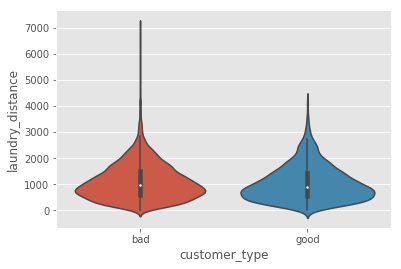

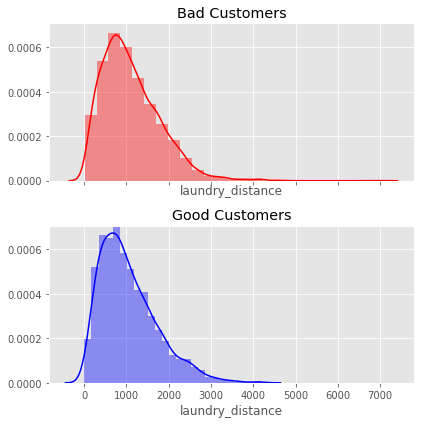

In [30]:
a = df_both.loc[(df_both.laundry_distance != -999), ['customer_type', 'laundry_distance']]
sns.categorical.violinplot(data=a, x='customer_type', y='laundry_distance')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'laundry_distance'], ax=ax1, color='red', bins=25)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'laundry_distance'], ax=ax2, color='blue', bins=25)
ax2.set_title('Good Customers')
plt.tight_layout()

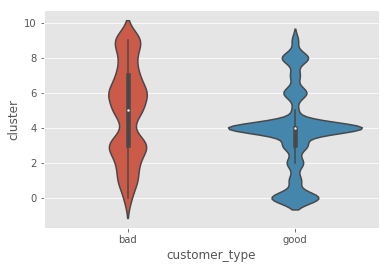

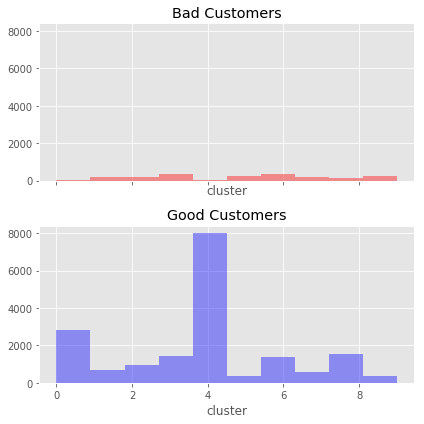

In [50]:
a = df_both.loc[~df_both.cluster.isnull(), ['customer_type', 'cluster']]
sns.categorical.violinplot(data=a, x='customer_type', y='cluster')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'cluster'], ax=ax1, color='red', kde=False, bins=10)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'cluster'], ax=ax2, color='blue', kde=False, bins=10)
ax2.set_title('Good Customers')
plt.tight_layout()

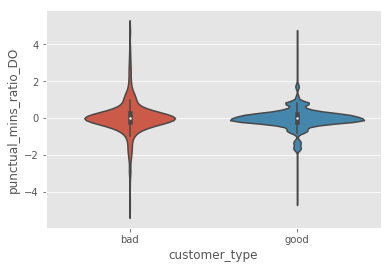

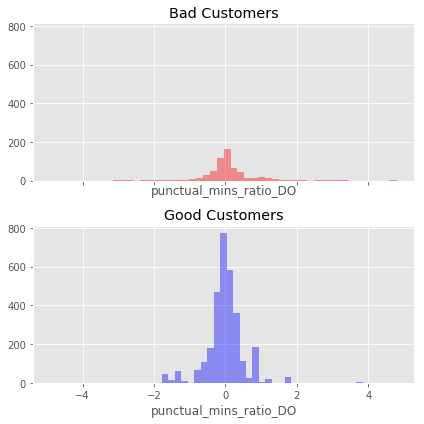

In [55]:
a = df_both.loc[(df_both.punctual_mins_ratio_DO > -5) &
                (df_both.punctual_mins_ratio_DO < 5) &
                (df_both.punctual_mins_ratio_DO != 0), 
                ['customer_type', 'punctual_mins_ratio_DO']]
sns.categorical.violinplot(data=a, x='customer_type', y='punctual_mins_ratio_DO')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'punctual_mins_ratio_DO'], ax=ax1, color='red', kde=False)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'punctual_mins_ratio_DO'], ax=ax2, color='blue', kde=False)
ax2.set_title('Good Customers')
plt.tight_layout()

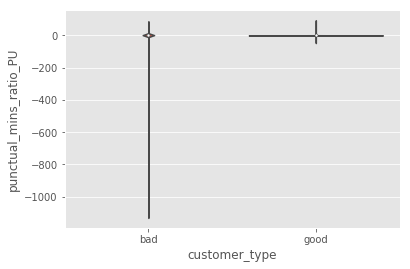

In [42]:
a = df_both[['customer_type', 'punctual_mins_ratio_PU']]
sns.categorical.violinplot(data=a, x='customer_type', y='punctual_mins_ratio_PU')

## Voucher Channel
*Assumption: The channel through which the customer has received the voucher influences if the acquired customer is going to come back after the first order.*

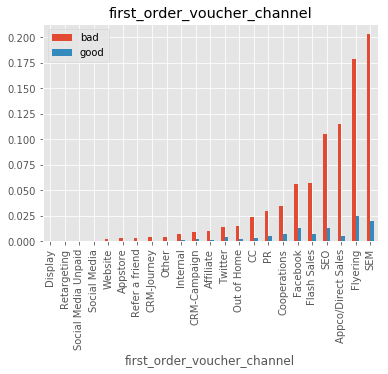

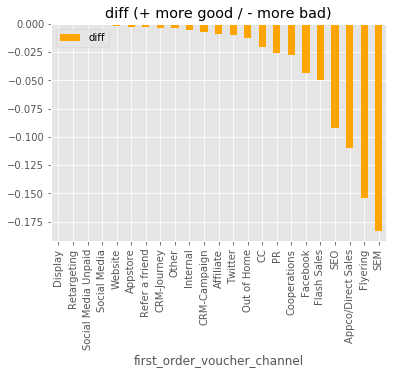

In [30]:
plot_bad_vs_good_by_column('first_order_voucher_channel')

Conclusion: Customers that have acquired their vouchers from the following channels are **likely to churn after first order, even if they had a good customer experience**, and should be excluded from the analysis.
* SEO
* SEM
* Appco/Direct Sales



In [31]:
bad_voucher_channels = ['SEO', 'SEM', 'Appco/Direct Sales']

## Voucher Value

customer_type                            bad          good
first_order_voucher_value count  7334.000000  18228.000000
                          mean     17.693735     15.242486
                          std      10.255416      7.141490
                          min       0.000000      0.000000
                          25%      11.887519     11.782549
                          50%      16.829412     13.780723
                          75%      19.276899     17.665047
                          max     182.227405    128.244158

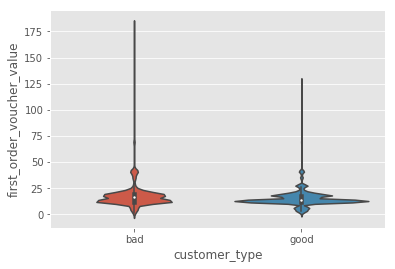

In [32]:
a = df_both.loc[df_both.first_order_voucher_value != -999, ['customer_type', 'first_order_voucher_value']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_voucher_value')

a.groupby('customer_type').describe().T

customer_type                                    bad         good
first_order_voucher_revenue_ratio count  6545.000000  2180.000000
                                  mean      0.605705     0.510217
                                  std       0.284457     0.298407
                                  min       0.000000     0.000000
                                  25%       0.381073     0.266667
                                  50%       0.615700     0.493151
                                  75%       0.860832     0.706159
                                  max       1.000000     1.000000

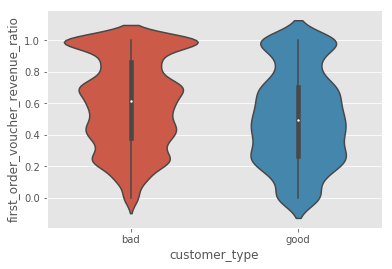

In [27]:
a = df_both.loc[df_both.first_order_voucher_revenue_ratio != np.inf, ['customer_type', 'first_order_voucher_revenue_ratio']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_voucher_revenue_ratio')

a.groupby('customer_type').describe().T

## First Order Revenue
*Assumption: Depending on how much the customer actually spent on their first voucher order, determines if they are going to order again or not. Customer who spend more, tend to be good customers, because they can afford our service regularly*

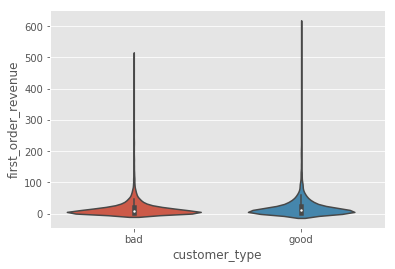

In [28]:
a = df_both[['customer_type', 'first_order_revenue']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_revenue')

customer_type                      bad         good
first_order_revenue count  6374.000000  2097.000000
                    mean     13.975492    16.320039
                    std      15.396492    16.865776
                    min       0.000000     0.000000
                    25%       2.412359     2.900022
                    50%       9.324413    11.602365
                    75%      19.527158    23.405499
                    max      78.943400    79.856491

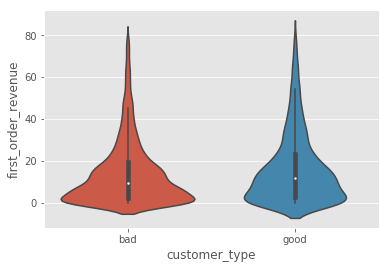

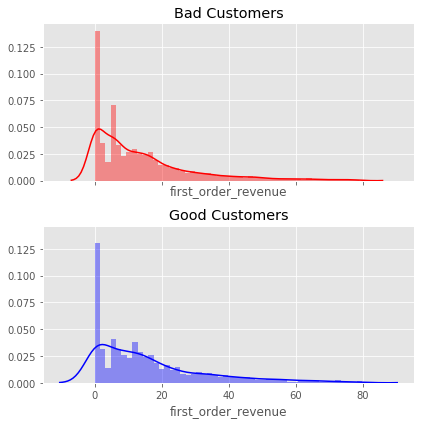

In [29]:
a = df_both.loc[df_both.first_order_revenue < 80, ['customer_type', 'first_order_revenue']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_revenue')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'first_order_revenue'], ax=ax1, color='red', bins=50)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'first_order_revenue'], ax=ax2, color='blue', bins=50)
ax2.set_title('Good Customers')
plt.tight_layout()

a.groupby('customer_type').describe().T

## Distance to Hub
*Assumption: The distance of the customer to the hub influences the availability he/she sees when they place an order.*

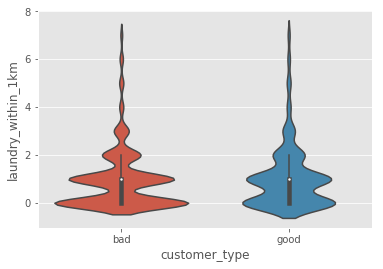

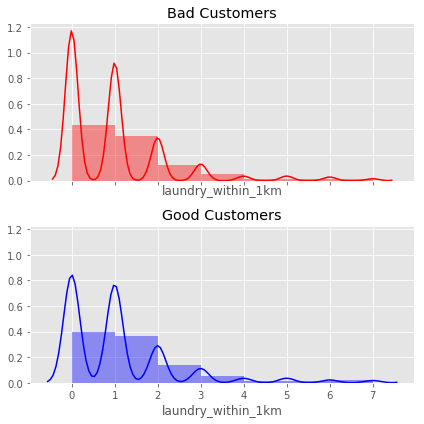

In [36]:
a = df_both.loc[(df_both.laundry_within_1km != -999) & (df_both.laundry_rating > 3), ['customer_type', 'laundry_within_1km']]
sns.categorical.violinplot(data=a, x='customer_type', y='laundry_within_1km')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'laundry_within_1km'], ax=ax1, color='red', bins=7)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'laundry_within_1km'], ax=ax2, color='blue', bins=7)
ax2.set_title('Good Customers')
plt.tight_layout()

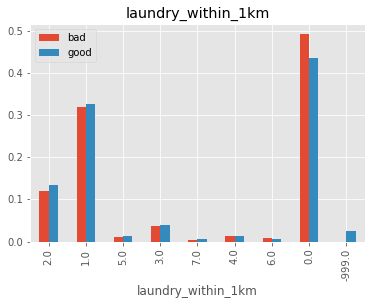

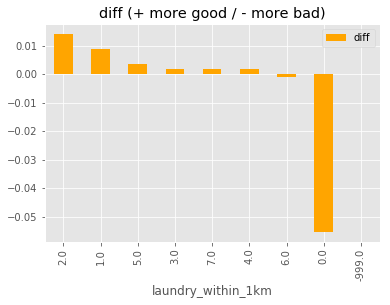

In [37]:
plot_bad_vs_good_by_column('laundry_within_1km')

*Conclusion*: It doesn't seem that distance to hub plays a role in the first_voucher_order churn.

In [ ]:
a = df_both.loc[df_both.first_order_hub_distance != -999, ['customer_type', 'first_order_hub_distance']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_hub_distance')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'first_order_hub_distance'], ax=ax1, color='red', bins=25)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'first_order_hub_distance'], ax=ax2, color='blue', bins=25)
ax2.set_title('Good Customers')
plt.tight_layout()

## Dates
*Assumption: The dates when more bad customers came than good, could mean that there was a certain period of campaigns that attracted undesirable customers.*

In [ ]:
bad_limit = df_vou_bad.loc[df_vou_bad.first_order_date < "2017-07-21"]
good_limit = df_vou_good.loc[df_vou_good.first_order_date < "2017-07-21"]
bad = bad_limit\
        .groupby('first_order_date')['customer_db_id']\
        .nunique() / bad_limit.shape[0]
good = good_limit\
        .groupby('first_order_date')['customer_db_id']\
        .nunique() / good_limit.shape[0]

df_plot = pd.concat([bad, good], axis=1, keys=['bad', 'good']).reset_index()
df_plot = df_plot.groupby([pd.Grouper(key='first_order_date', freq='MS')])[['bad', 'good']]\
        .sum()\
        .reset_index()\
        .sort_values('first_order_date')\
        .set_index('first_order_date')

In [ ]:
df_plot.plot()

*Conclusion*: Seems that there were some areas, especially around Feb - April 2016, where loads of "bad customers" were coming in. We should look at what kind of campaigns there were running at that time.

## Facility
*Assumption: Some facilities provide better services and therefore customers who churned after first order, although having a 'good' facility, are concidered bad.*

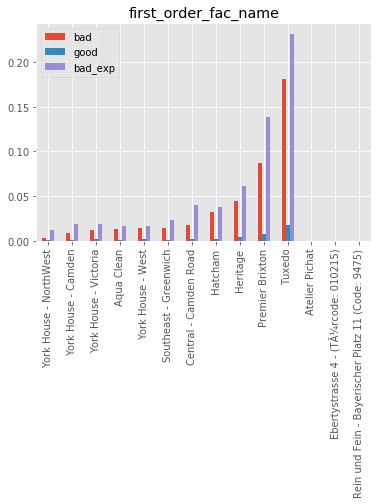

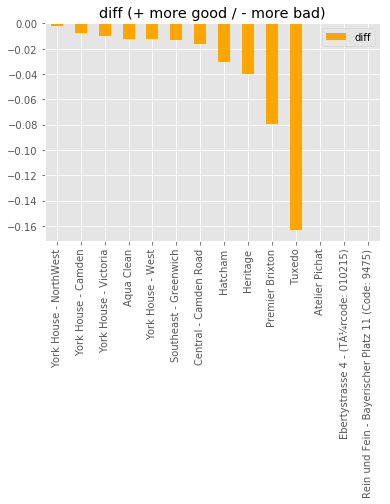

In [44]:
df_bad = df_vou_bad.loc[df_vou_bad.first_order_fac_name != "unknown"]\
        .groupby('first_order_fac_name')['customer_db_id'].nunique() / df_vou_bad.shape[0]
df_good = df_vou_good.loc[df_vou_good.first_order_fac_name != "unknown"]\
        .groupby('first_order_fac_name')['customer_db_id'].nunique() / df_vou_good.shape[0]
df_bad_exp = df_vou_bad_exp.loc[df_vou_bad_exp.first_order_fac_name != "unknown"]\
        .groupby('first_order_fac_name')['customer_db_id'].nunique() / df_vou_bad_exp.shape[0]
df_diff = df_good - df_bad
df_diff_relative = df_diff / (df_bad + df_good)
df = pd.concat([df_bad, df_good, df_bad_exp, df_diff, df_diff_relative], 
              axis=1, keys=['bad', 'good', 'bad_exp', 'diff', 'diff_relative'], sort=True)

df = df.sort_values('diff', ascending=False)
df[['bad', 'good', 'bad_exp']].plot(kind='bar', title='first_order_fac_name')
df[['diff']].plot(kind='bar', title='diff (+ more good / - more bad)', color='orange')

In [ ]:
df_bad = df_vou_bad.loc[df_vou_bad.first_order_fac_name != "unknown"]\
        .groupby('first_order_fac_name')['customer_db_id'].nunique() / df_vou_bad.shape[0]

## Product Segmentation
*Assumption: Bad customers order certain type of products*

TODO: too many UNKNOWN values for bad customers, need to include itemization

In [ ]:
plot_bad_vs_good_by_column('first_order_products')

## Dates
*Assumption: There is a certain pattern in the recency of the second order for the good customers.*

In [ ]:
sns.distplot(df_vou_good.first_order_recency)

In [ ]:
df_vou_good.first_order_recency.describe()

# Correlations

In [ ]:
df_both.columns

In [ ]:
df_good = df_vou_good.loc[df_vou_good.first_order_voucher_value != -999].sample(df_vou_bad.shape[0])
df_bad = df_vou_bad.copy()
df_sample = pd.concat([df_good, df_bad])
df_sample['customer_type_enc'] = df_sample['customer_type'].map({'bad': -1, 'good': 1})

print('Bad: {}, Good: {}'.format(df_bad.shape[0], df_good.shape[0]))

In [ ]:
features = ['customer_type_enc', 'first_order_products_enc', 'first_order_voucher_channel_enc', 
            'first_order_voucher_value', 'first_order_revenue',             'first_order_voucher_revenue_ratio']
df_plot = df_sample[features]

In [ ]:
df_plot.corr()

In [ ]:
sns.heatmap(df_plot.corr(), 
            xticklabels=df_plot.corr().columns.values,
            yticklabels=df_plot.corr().columns.values)

In [ ]:
X = df_plot[df_plot.columns.tolist()[1:]].values
y = df_plot['customer_type_enc'].values

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
neigh = DecisionTreeClassifier()
neigh.fit(X, y)

In [ ]:
neigh.feature_importances_

In [ ]:
pd.DataFrame(index=df_plot.columns.tolist()[1:], data=neigh.feature_importances_)